In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from scipy import stats
import numpy.linalg as alg
import seaborn as sns

In [65]:
data = pd.read_csv('bank-additional-filtered.csv').iloc[:, 1:]
data.drop('pdays', axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

In [67]:
numeric_cols = ['age',	'duration',	'campaign',	'previous', 'nr.employed']
object_cols = set(data.columns) - set(numeric_cols) 
object_cols = set(data.columns) - set(data.select_dtypes(include=np.number).columns) 

In [68]:
data_numeric = data[numeric_cols]
data_object = data[object_cols]
y = data['y']

In [69]:
data_object

,marital,active,education,basic_education,housing,month,loan,poutcome,y,age_binned,day_of_week,contact,job
0,married,False,basic_4y,True,no,may,no,nonexistent,no,"(25, 65]",mon,False,housemaid
1,married,True,high_school,False,no,may,no,nonexistent,no,"(25, 65]",mon,False,services
2,married,True,high_school,False,yes,may,no,nonexistent,no,"(25, 65]",mon,False,services
3,married,True,basic_6y,True,no,may,no,nonexistent,no,"(25, 65]",mon,False,admin.
4,married,True,high_school,False,no,may,yes,nonexistent,no,"(25, 65]",mon,False,services
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,married,False,professional_course,False,yes,nov,no,nonexistent,yes,"(65, 98]",fri,False,retired
41184,married,True,professional_course,False,no,nov,no,nonexistent,no,"(25, 65]",fri,False,blue-collar
41185,married,False,university_degree,False,yes,nov,no,nonexistent,no,"(25, 65]",fri,False,retired
41186,married,True,professional_course,False,no,nov,no,nonexistent,yes,"(25, 65]",fri,False,technician


# 1. U-Mann-Whitney y Chi-Square

In [39]:
def wilcoxon_test(df1, df2):
  
    list_col_1 = df1.columns
    list_col_2 = df2.columns
    dict_column = {}

    for i in range(0, len(list_col_1)):
        pvalue_list = []
        name_row = []
        name = list_col_1[i]
        for j in range(0, len(list_col_2)):
            name_check = list_col_2[j]
            name_row.append(name_check)
            stat, pvalue = stats.mannwhitneyu(df1[name], df2[name_check])
            pvalue_list.append(round(pvalue, 2))

        dict_column.update({str(name): pvalue_list})

    df = pd.DataFrame(dict_column)
    df.reset_index(inplace = True)
    df.loc[:, ['Name']] = name_row
    df = df.set_index(['Name'])
    df = df.drop('index', axis = 1)

    return df

In [40]:
wilcoxon_test(data_numeric, data_numeric)

,age,duration,campaign,previous,nr.employed
Name,,,,,
age,1.00,0.85,0.00,0.00,0.0
duration,0.85,1.00,0.00,0.00,0.0
campaign,0.00,0.00,1.00,0.48,0.0
previous,0.00,0.00,0.48,1.00,0.0
nr.employed,0.00,0.00,0.00,0.00,1.0


Se deben eliminar una de cada par de variables (age, duration) y (previous, campaign)

In [101]:
def chisquare_test(df1, df2):
  
    list_col_1 = df1.columns
    list_col_2 = df2.columns
    dict_column = {}

    for i in range(0, len(list_col_1)):
        pvalue_list = []
        name_row = []
        name = list_col_1[i]
        for j in range(0, len(list_col_2)):
            name_check = list_col_2[j]
            name_row.append(name_check)
            pvalue = stats.chisquare(pd.crosstab(df1[name], df2[name_check]))[1][0]
            pvalue_list.append(round(pvalue, 2))

        dict_column.update({str(name): pvalue_list})

    df = pd.DataFrame(dict_column)
    df.reset_index(inplace = True)
    df.loc[:, ['Name']] = name_row
    df = df.set_index(['Name'])
    df = df.drop('index', axis = 1)

    return df

In [106]:
result = chisquare_test(data_object, data_object)

<AxesSubplot:ylabel='Name'>

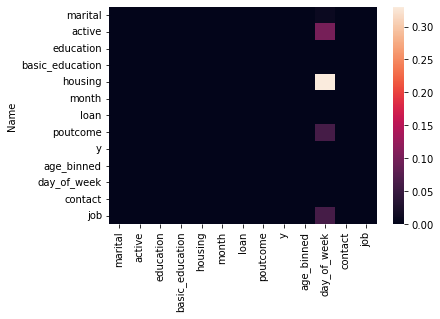

In [107]:
sns.heatmap(result)

# Ejercicio 2

In [124]:
x, y = data_numeric, data['y']
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(x, y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = x.columns
mutual_info.sort_values(ascending=False)

duration       0.078075
nr.employed    0.065234
previous       0.022550
age            0.014651
campaign       0.004007
dtype: float64

# Ejercicio 3. LDA

In [43]:
lda = LinearDiscriminantAnalysis(n_components=1, store_covariance=True).fit(data_numeric, data['y'])

In [46]:
alg.eig(lda.covariance_)[1][0]

array([ 0.04281229, -0.01242568,  0.78965929,  0.61164648, -0.01842542])

(array([2.5845e+04, 1.2140e+04, 2.6660e+03, 4.1600e+02, 7.8000e+01,
        2.5000e+01, 1.2000e+01, 2.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([-1.53447196,  0.14377981,  1.82203158,  3.50028336,  5.17853513,
         6.8567869 ,  8.53503867, 10.21329044, 11.89154221, 13.56979398,
        15.24804575]),
 <BarContainer object of 10 artists>)

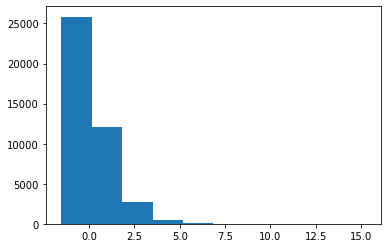

In [51]:
plt.hist(lda.transform(data_numeric)) # histograma de la proyeccion

In [50]:
lda.covariance_ @ (lda.means_[0]-lda.means_[1]) # vector de proyecccion

array([-0.09846619, -0.91519886,  0.44780396, -1.083106  ,  1.18610775])

# Ejercicio 4. PCA

In [72]:
pca = PCA().fit(data_numeric, y)

In [73]:
pca.explained_variance_ratio_

array([0.31119184, 0.2077373 , 0.1992294 , 0.18313077, 0.09871069])

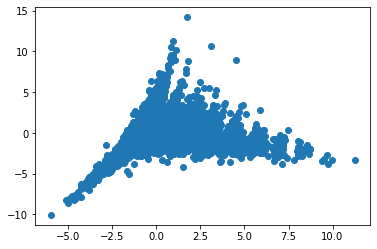

In [78]:
transformed = pca.transform(data_numeric)[:, :2]
plt.scatter(transformed[:, 0], transformed[:, 1])

In [80]:
# falta la matriz de proyeccion